# Using Sensitivity Analysis to Interrogate Models

Will Usher, UCL Energy Institute

10th December 2015

## How to use this notebook

There are several alternative ways in which you can use this notebook.
1. Access online here [![Binder](http://mybinder.org/badge.svg)](http://mybinder.org/repo/willu47/SATut) (changes won't be saved)
2. [Download](http://www.github.com/willu47/SATut) the notebooks, and install jupyter and python
    1. For Mac, open terminal and type
        `pip install jupyter notebook ipython`
    2. For Windows

# Agenda

1. [What is Sensitivity Analysis?](#What-is-Sensitivity-Analysis?)
1. [Sensitivity Analysis Techniques](#Sensitivity-Analysis-Techniques)
1. [An Interactive Example](#Sensitivity-Analysis-in-Practice:-Vehicle-to-Grid)
1. [Summary](#Summary)

In [7]:
from ipywidgets import widgets, interact
from IPython.display import display
%matplotlib inline
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
figsize(12, 10)
sbn.set_context("talk", font_scale=1)

# The model used for this seminar is contained in the file model.py
from model import cost_of_vehicle_to_grid, compute_profit, annualized_capital_cost, battery_lifetime, max_vehicle_power

In [8]:
# %load model.py

# # Using Sensitivity Analysis to Interrogate Models
#
# Will Usher, UCL Energy Institute
#
# 10th December 2015

'''
Revenue = Max Power * Daily Capacity Payment * (Time Available/24) + Electricity Exported * Electricity Price
        = Max Power * Daily Capacity Payment * (Time Available/24) + Max Power * Time Available * Electricity Price

Alternatives:

Use a BEV for V2G overnight, although power is constrained by:
    1. need to charge vehicle
    2. size of battery
    3. size of connection
    4. requirements for range buffer
    5. distance driven per day

 Use a separate battery:
     1. charge during times of cheap electricity
     2. extra expense of purchasing battery
     3. size of connection is constrained

Max_Power = max(0, min(connection, available_energy / duration)

duration/24 * Max_Power * Capacity Payment
'''


import numpy as np

def max_vehicle_power(connector_power,
                      stored_energy,
                      distance_driven,
                      range_buffer,
                      dispatch_time,
                      driving_efficiency=4.025,
                      inverter_efficiency=0.93
                      ):
    '''
    Compute the maximum electrical power output of a vehicle battery when
    connected to the electricity grid

    Arguments:
        connector_power - the power capacity of the connection to the grid
        stored_energy - energy available as DC kWh to the inverter
        distance_driven - distance driven (km) since energy storage full
        range_buffer - minimum range required by the driver (km)
        driving_efficiency - 4.025 (km/kWh)
        inverter_efficiency - electrical conversion efficiency of DC to AC
                              inverter (93%)
        dispatch_time - time over which the vehicle's stored energy
                        is dispatched (hours)

    Returns:
        the maximum power in kW of a vehicle connected to the grid
    '''


    max_vehicle_power = ((stored_energy - ((distance_driven + range_buffer) / driving_efficiency)) * \
    inverter_efficiency)  / dispatch_time

    return np.maximum(0, np.minimum(connector_power, max_vehicle_power))


def battery_lifetime(lifetime_cycles,
                     total_energy_stored,
                     depth_of_discharge
                    ):
    '''
    Compute the lifetime of a battery in energy terms

    Arguments:
        lifetime_cycles -
        total_energy_stored - size of battery (kWh)
        depth_of_discharge - the depth of discharge for which
                            lifetime_cycles is defined (0 <= DoD <= 1)

    Returns:
        battery_lifetime in energy terms - units: kWh

    '''
    lifetime = lifetime_cycles * total_energy_stored * depth_of_discharge
    return lifetime


def annualized_capital_cost(cost, discount_rate, lifetime):
    '''
    Arguments:
        cost - in GBP2015
        discount_rate - %
        lifetime - in years
    '''
    ann_cc = cost * (discount_rate / (1-(1+discount_rate)**-lifetime))
    return ann_cc


def cost_of_vehicle_to_grid(
                            battery_capital_cost,
                            lifetime_cycles,
                            total_energy_stored,
                            depth_of_discharge,
                            purchased_energy_cost,
                            round_trip_efficiency,
                            energy_dispatched,
                            cost_of_v2g_equip,
                            discount_rate,
                            economic_lifetime):

    battery_life = battery_lifetime(lifetime_cycles,
                                    total_energy_stored,
                                    depth_of_discharge
                                    )

    degredation_cost = battery_capital_cost / battery_life

    cost_of_energy = (purchased_energy_cost / round_trip_efficiency)                         + degredation_cost

    annualised_capex = annualized_capital_cost(cost_of_v2g_equip,
                                               discount_rate,
                                               economic_lifetime)

    cost = (cost_of_energy * energy_dispatched) + annualised_capex

    return cost


def compute_profit(
        battery_size = 70, # kWh
        battery_unit_cost = 350, # £/kWh
        connector_power = 14, # kW
        lifetime_cycles = 2000,
        depth_of_discharge = 0.8,
        electricity_price = 0.1, # £/kWh - sell when its expensive
        purchased_energy_cost = 0.05, # £/kWh - buy when it's cheap
        capacity_price = 0.007, # £\kWh
        round_trip_efficiency = 0.73, # 73% efficiency grid-battery-grid
        cost_of_v2g_equip = 2000,
        discount_rate = 0.1, # 10%
        economic_lifetime = 10,
        distance_driven = 0, # km
        range_buffer = 0, # km
        ratio_dispatch_to_contract = 0.1,
        hours_connected_per_day = 18):
    '''
    Computes the profit (revenue-cost) of using vehicle for regulation services
    '''
    battery_capital_cost = battery_size * battery_unit_cost # 2015£

    stored_energy = battery_size * depth_of_discharge # kWh

    total_hours_connected = hours_connected_per_day * 365

    time_dispatched = total_hours_connected * ratio_dispatch_to_contract # hours

    power_available = max_vehicle_power(connector_power,
                                        stored_energy,
                                        distance_driven,
                                        range_buffer,
                                        hours_connected_per_day * ratio_dispatch_to_contract,
                                        )

    energy_dispatched = ratio_dispatch_to_contract * power_available * time_dispatched

    revenue = capacity_price * power_available * total_hours_connected + electricity_price * energy_dispatched

    cost = cost_of_vehicle_to_grid(battery_capital_cost,
                                   lifetime_cycles,
                                   battery_size,
                                   depth_of_discharge,
                                   purchased_energy_cost,
                                   round_trip_efficiency,
                                   energy_dispatched,
                                   cost_of_v2g_equip,
                                   discount_rate,
                                   economic_lifetime)

    profit = revenue - cost
    return profit, revenue, cost

if __name__ == "__main__":
    pass

# Uncertainty and Modelling

We use models to encode natural phenomena, to project and forecast, to understand, to learn.

Examples of models:
* discounted cash flow analysis
* [Gina coefficient](https://en.wikipedia.org/wiki/Gini_coefficient#Based_on_just_two_levels_of_income) (statistical measure of inequality)
* UKTM - energy system model of the United Kingdom
* [MetUM](http://www.metoffice.gov.uk/research/modelling-systems/unified-model) - UK weather forecasting

## What is Sensitivity Analysis?

“...the study of how the uncertainty in the output of a mathematical model or system (numerical or otherwise) can be apportioned to different sources of uncertainty in its inputs.” 

There are four settings for sensitivity analysis:
* **Factor prioritisation** - which parameters are most influential?
* **Factor fixing** - which parameters can we ignore?
* Factor mapping - which inputs matter for just this space in the model output?
* (Metamodelling) - which parameters can I use to model my model?

There are two families of approaches:
* Local approaches
* Global approaches

### Local versus Global Approaches

* Local approaches
    * e.g. one-at-a-time (OAT) approach
    * low data requirements
    * quick and easy to conduct
    * do not capture interactions between inputs
    * misleading for non-linear models


* Global approaches
    * e.g. Sobol analysis
    * often need probabilistic data
    * computationally demanding
    * capture interactions between inputs
    * handle non-linear and non-additive models

### Sensitivity Analysis Techniques 

(adapted from Flechsig (2012), Saltelli(2008))

| Type | Morris | Variance | Factorial | Monte Carlo | Local SA |
|:------|------|------|------|------|------|
|Model independent? | yes | yes | yes | yes | yes|
|Sample source | levels | distributions | levels | distributions | levels |
|No. factors | $20-100^1$ | $<20^1$ | $>100^1$ | $<20$ | $<100$ |
|Factor range | global | global | global | global | local |
|Multi-factor variation | yes | yes | yes | yes | no |
|Correlated factors? | no | no | yes | yes | no |
|Cost (for k factors)? | $10(k+1)$ | $500(k+2)$ | $k \to 2k$ | $500+1$ | $2(k+1)$ |
|Estimated CPU time$^2$ | 1 day | 11 days | 3 hours | ~2 days | 1 hour |
  
[1] using groups of factors would enable larger numbers of factors to be explored
[2] assuming 5 minutes per simulation and 30 groups of factors

Sensitivity Analysis is strongly linked to uncertainty.

When considering the range over which a mode input should be explored, 
you are actually considering the plausibility of this range.

Sensitivity Analysis makes you critically analyse your assumptions.

### Global Sensitivity Analysis

Screening approaches, such as Fractional Factorial and Morris, **rank** inputs according to their influence upon the output.

Variance-based approaches, such as Saltelli and DMIM, **score** the sensitivity of each input with a numerical value, called the sensitivity index. Sensitivity indices come in several forms:
* First-order indices: measures the contribution to the output variance by a single model input alone.
* Second-order indices: measures the contribution to the output variance caused by the interaction of two model inputs.
* Total-order index: measures the contribution to the output variance caused by a model input, including both its first-order effects (the input varying alone) and all higher-order interactions.

# Sensitivity Analysis in Practice: Vehicle to Grid

[Kempton (2005)](http://www.sciencedirect.com/science/article/pii/S0378775305000352) raise the prospect of using battery electric vehicles (BEVs) as mobile storage devices for electricity.  Other than pumped hydro, the electricity grid has virtually no storage devices.  Electricity storage could facilitate the integration of variable output renewable technologies such as wind turbines and solar photovoltaics.

The concept of V2G is that the owners of electric (or even hydrogen fuel cell) vehicles could be paid by the System Operator (National Grid in the UK) for the use of their cars as giant batteries.

There are three services that Vehicle-to-Grid (V2G) could provide:
* Regulation - helps keep the grid operating at 60 Hz by exporting energy during times of extra demand or importing during times of extra supply
* Spinning Reserve - an always-available (but not necessarily generating) backup in case a power plant drops offline
* Peak Power - exports electricity to the grid during times of peak demand (e.g. 5-7pm)

We'll just look at **regulation** services:


|Service | Revenue | Cost|
 |---- | ---- | ----|
 |**Regulation** | Energy Exported, Saving on Energy Imported | Cost of Energy, Degradation of Battery|
 |Spinning Reserve | Capacity Available, Energy Exported | Cost of Energy, Degradation of Battery|
 |Peak Power | Capacity Available, Energy Exported | Cost of Energy, Degradation of Battery|

## Tesla Model S

![Tesla](https://www.teslamotors.com/sites/default/files/images/model-s/gallery/exterior/hero-01.jpg?20151030)

Parameter | Min | Max
---| ---| ---
Battery Size | 70 kWh | 85 kWh
Charge Connectors | 230V 10 Amp (2.3 kW) | 400V 32 Amp (22 kW)
Stated efficiency | ~ 5.5 km/kWh |

## Nissan Leaf

![Nissan Leaf](http://www.nissan.co.uk/content/dam/pes/default/leaf/galleries/photos/exterior_view/720x450/gallery_0000_01.jpg)

Parameter | Min | Max
---| ---| ---
Battery Size | 24 kWh | 30 kWh
Charge Connectors | 2.3 kW | 6.6 kW
Stated efficiency | ~5.5 km/kWh |

### One-at-time approach

First, we're going to try the **one-at-a-time** (OAT) approach.

Find the sliders in the example which are set up for the parameters of the Nissan Leaf.

In [9]:
@interact(connector=widgets.FloatSlider(value=2.3, min=2.3, max=22, step=0.5), 
          battery_size=widgets.FloatSlider(value=24, min=10, max=100, step=5), 
          distance_driven=widgets.FloatSlider(value=0, min=0, max=100, step=5), 
          range_buffer=widgets.FloatSlider(value=0, min=0, max=100, step=10),
          dispatch_time=widgets.FloatSlider(value=1.4, min=0.5, max=24, step=0.5))
def plot_power(connector, battery_size, distance_driven, range_buffer, dispatch_time):
    power = max_vehicle_power(connector,
                      battery_size,
                      distance_driven,
                      range_buffer,
                      dispatch_time
                      )
    return print("The maximum power is {} kW".format(round(power, 2)))

The maximum power is 2.27 kW


In [11]:
def monte_carlo_large(data):
    dispatch_time = 4
    y = max_vehicle_power(data[0], data[1], data[2], data[3], data[6], data[4], data[5])
    return y

### Scatter plots

Scatter plots can tell you quite a lot about the relationship between the model inputs and outputs.

Each of the scatter plots shows _all_ the model outputs on the y-axis, but re-ordered by the relatinship to the input variable (on the x-axis).

![Scatter Plot](./scatter.png)

In [12]:
number_sims = 1000

# Make some random data in the correct ranges
mc_connector = np.random.uniform(2.3, 22, number_sims)
mc_battery_size = np.random.uniform(50, 100, number_sims)
mc_distance_driven = np.random.uniform(0, 80, number_sims)
mc_range_buffer = np.random.uniform(0, 80, number_sims)
mc_driving_eff = np.random.uniform(2, 6, number_sims)
mc_inv_eff = np.random.uniform(0.87, 0.97, number_sims)
mc_dispatch_time = np.random.uniform(0.5, 24, number_sims)

data = np.array((mc_connector, 
                 mc_battery_size, 
                 mc_distance_driven, 
                 mc_range_buffer, 
                 mc_driving_eff, 
                 mc_inv_eff, 
                 mc_dispatch_time))

# Run the code
y = monte_carlo_large(data)

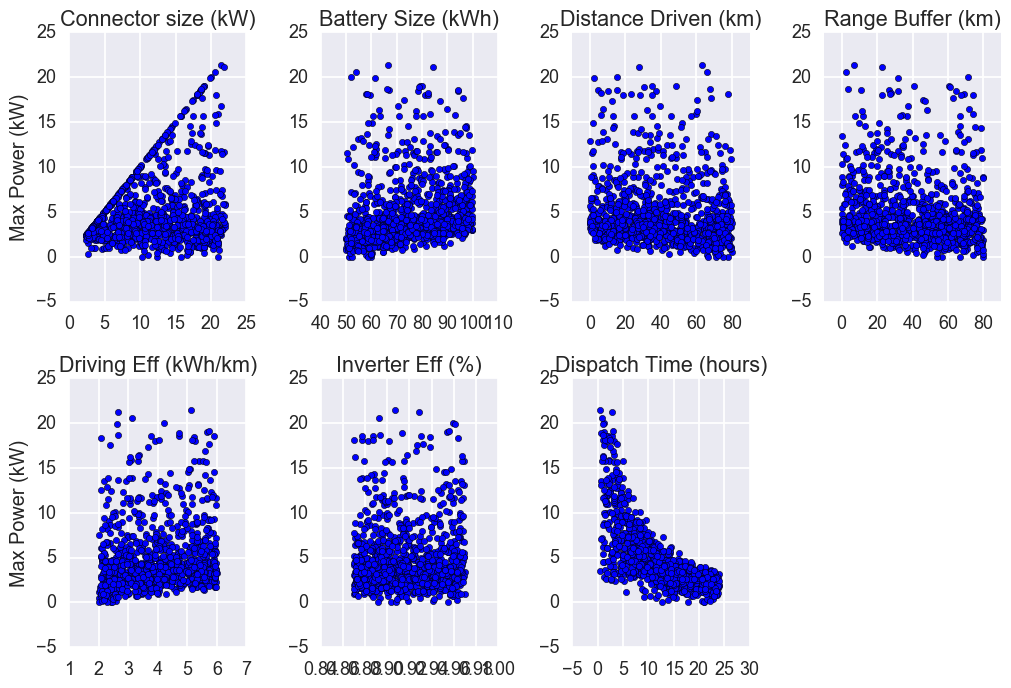

In [13]:
# Make some scatter plots to compare the results
plt.subplot(241)
plt.scatter(mc_connector, y)
plt.title("Connector size (kW)")
plt.ylabel("Max Power (kW)")
plt.subplot(242)
plt.scatter(mc_battery_size, y)
plt.title("Battery Size (kWh)")
# plt.ylabel("Max Power (kW)")
plt.subplot(243)
plt.scatter(mc_distance_driven, y)
plt.title("Distance Driven (km)")
# plt.ylabel("Max Power (kW)")
plt.subplot(244)
plt.scatter(mc_range_buffer, y)
plt.title("Range Buffer (km)")
# plt.ylabel("Max Power (kW)")
plt.subplot(245)
plt.scatter(mc_driving_eff, y)
plt.title("Driving Eff (kWh/km)")
plt.ylabel("Max Power (kW)")
plt.subplot(246)
plt.scatter(mc_inv_eff, y)
plt.title("Inverter Eff (%)")
# plt.ylabel("Max Power (kW)")
plt.subplot(247)
plt.scatter(mc_dispatch_time, y)
plt.title("Dispatch Time (hours)")
# plt.ylabel("Max Power (kW)")
plt.tight_layout()
# plt.savefig('scatter.png')

You might be tempted to plot a histogram of the model outputs.  This shows how often a particular value occurs in the results, but given that we are only exploring the model variable ranges, don't read too much into this distribution.


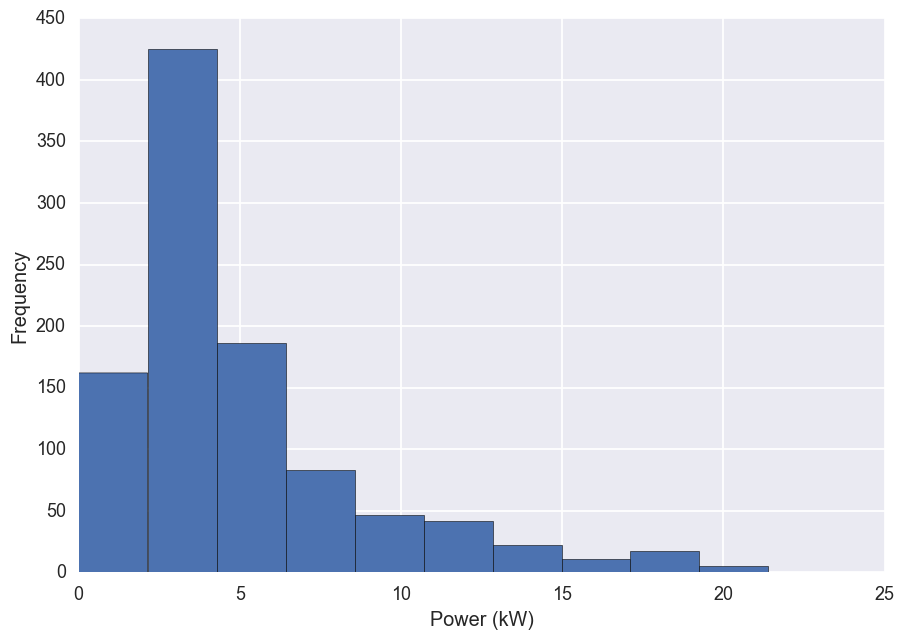

In [14]:
plt.hist(y)
plt.xlabel("Power (kW)")
plt.ylabel("Frequency")

# Using SALib to run a Sensitivity Analysis

SALib is a **free** **open-source** **Python** library

If you use Python, you can install it by running the command

```python
pip install SALib
```

[Documentation](http://salib.readthedocs.org/) is available online and you can also view the code on [Github](http://salib.github.io/SALib/).

The library includes:
* Sobol Sensitivity Analysis ([Sobol 2001](http://www.sciencedirect.com/science/article/pii/S0378475400002706), [Saltelli 2002](http://www.sciencedirect.com/science/article/pii/S0010465502002801), [Saltelli et al. 2010](http://www.sciencedirect.com/science/article/pii/S0010465509003087))
* Method of Morris, including groups and optimal trajectories ([Morris 1991](http://www.tandfonline.com/doi/abs/10.1080/00401706.1991.10484804), [Campolongo et al. 2007](http://www.sciencedirect.com/science/article/pii/S1364815206002805))
* Fourier Amplitude Sensitivity Test (FAST) ([Cukier et al. 1973](http://scitation.aip.org/content/aip/journal/jcp/59/8/10.1063/1.1680571), [Saltelli et al. 1999](http://amstat.tandfonline.com/doi/abs/10.1080/00401706.1999.10485594))
* Delta Moment-Independent Measure ([Borgonovo 2007](http://www.sciencedirect.com/science/article/pii/S0951832006000883), [Plischke et al. 2013](http://www.sciencedirect.com/science/article/pii/S0377221712008995))
* Derivative-based Global Sensitivity Measure (DGSM) ([Sobol and Kucherenko 2009](http://www.sciencedirect.com/science/article/pii/S0378475409000354))
* Fractional Factorial Sensitivity Analysis ([Saltelli et al. 2008](http://www.wiley.com/WileyCDA/WileyTitle/productCd-0470059974.html))


### Import the package

In [15]:
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp

### Define a problem file

In the code below, a problem file is used to define the variables we wish to explore

In [16]:
morris_problem = {
    # There are six variables
    'num_vars': 7,
    # These are their names
    'names': ['conn', 'batt', 'dist', 'range', 'dri_eff', 'inv_eff', 'dispatch_time'],
    # These are their plausible ranges over which we'll move the variables
    'bounds': [[2.3, 22], # connection_power (kW)
               [50, 100], # battery size (kWh)
               [0, 80], # distance driven (km)
               [0, 80], # range buffer (km)
               [4,5.5], # driving efficiency (kWh/km)
               [0.87,0.97], # inverter efficienct (%)
               [0.5, 24] # dispatch time - hours of the day in which the energy is dispatched
              ],
    # I don't want to group any of these variables together
    'groups': None
    }

### Generate a Sample

We then generate a sample using the `morris.sample()` procedure from the SALib package.

In [28]:
number_of_trajectories = 1000
sample = ms.sample(morris_problem, number_of_trajectories, num_levels=4, grid_jump=2)
sample.shape
for j in range(10):
    print(' '.join(['{:.3f}'.format(i) for i in sample[j]]))


2.300 100.000 26.667 0.000 4.000 0.870 0.500
15.433 100.000 26.667 0.000 4.000 0.870 0.500
15.433 100.000 26.667 53.333 4.000 0.870 0.500
15.433 100.000 80.000 53.333 4.000 0.870 0.500
15.433 66.667 80.000 53.333 4.000 0.870 0.500
15.433 66.667 80.000 53.333 5.000 0.870 0.500
15.433 66.667 80.000 53.333 5.000 0.870 16.167
15.433 66.667 80.000 53.333 5.000 0.937 16.167
8.867 100.000 26.667 53.333 5.500 0.970 24.000
8.867 66.667 26.667 53.333 5.500 0.970 24.000


### Factor Prioritisation

We'll run a sensitivity analysis of the power module to see which is the most influential parameter.

The results parameters are called **mu**, **sigma** and **mu_star**.

* **Mu** is the mean effect caused by the input parameter being moved over its range.
* **Sigma** is the standard deviation of the mean effect.
* **Mu_star** is the mean absolute effect.

In [31]:
# Run the sample through the monte carlo procedure of the power model
output = monte_carlo_large(sample.T)
# Store the results for plotting of the analysis
Si = ma.analyze(morris_problem, sample, output, print_to_console=False)
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mu", "mu_star", "sigma"))
for name, s1, st, mean in zip(morris_problem['names'], Si['mu'], Si['mu_star'], Si['sigma']):
    print("{:20s} {:=7.2f} {:=7.2f} {:=7.2f}".format(name, s1, st, mean))

Name                      mu mu_star   sigma
conn                    6.04    6.04    8.27
batt                    2.01    2.01    1.95
dist                 -  0.69    0.69    0.68
range                -  0.67    0.67    0.68
dri_eff                 0.23    0.23    0.35
inv_eff                 0.23    0.23    0.27
dispatch_time        -  9.11    9.11    8.90


We can plot the results

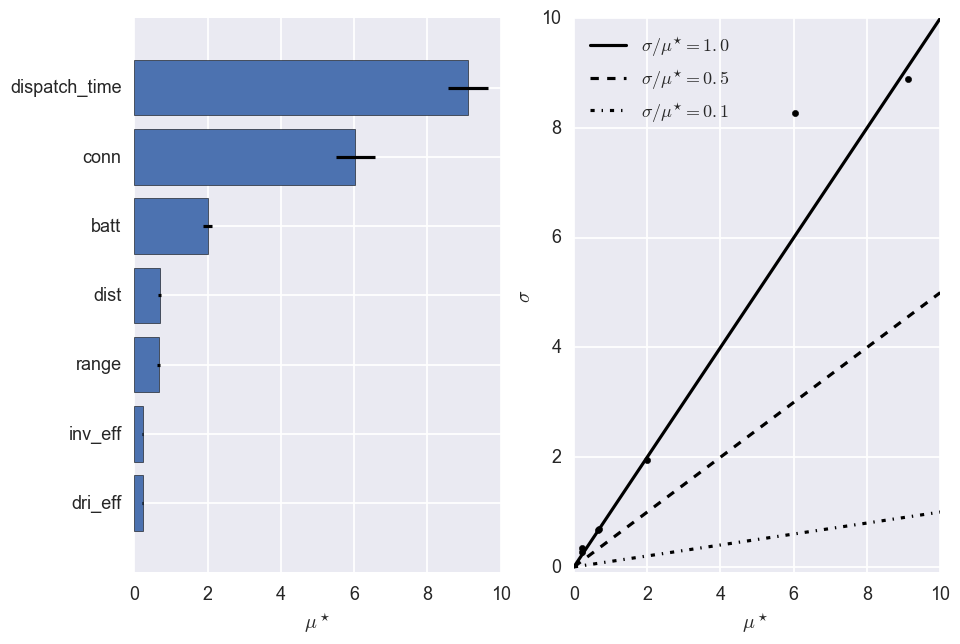

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2)
mp.horizontal_bar_plot(ax1, Si, param_dict={})
mp.covariance_plot(ax2, Si, {})

## A More Complicated Example

Lets look at a more complicated example.  This now integrates the previous power module into a simple cost-benefit analysis.

Trying to work out anything with all those sliders is pretty difficult.  We need to strip out the uneccesssary parameters and focus our efforts on the influential inputs.

In [34]:
@interact(battery_size=widgets.FloatSlider(value=24, min=10, max=100, step=5), 
          battery_unit_cost=widgets.FloatSlider(value=350, min=100, max=400, step=50),
          connector_power=widgets.FloatSlider(value=2.3, min=2.3, max=22, step=0.5), 
          lifetime_cycles=widgets.FloatSlider(value=2000, min=1000, max=10000, step=1000),
          depth_of_discharge=widgets.FloatSlider(value=0.8, min=0.5, max=1.0, step=0.1),
          electricity_price=widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01),
          purchased_energy_cost=widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01),
          capacity_price=widgets.FloatSlider(value=0.007, min=0.001, max=0.01, step=0.001),
          round_trip_efficiency=widgets.FloatSlider(value=0.73, min=0.50, max=1.0, step=0.01),
          cost_of_v2g_equip=widgets.FloatSlider(value=2000, min=100, max=5000, step=100),
          discount_rate=widgets.FloatSlider(value=0.10, min=0.0, max=0.2, step=0.01),
          economic_lifetime=widgets.FloatSlider(value=10, min=3, max=25, step=1),
          ratio_dispatch_to_contract=widgets.FloatSlider(value=0.10, min=0.01, max=0.50, step=0.01),
          distance_driven=widgets.FloatSlider(value=0, min=0, max=100, step=5), 
          range_buffer=widgets.FloatSlider(value=0, min=0, max=100, step=10),
          hours_connected_per_day=widgets.FloatSlider(value=18, min=0.5, max=24, step=0.5))
def plot_profit(battery_size,
                battery_unit_cost,
                connector_power,
                lifetime_cycles,
                depth_of_discharge,
                electricity_price,
                purchased_energy_cost,
                capacity_price,
                round_trip_efficiency,
                cost_of_v2g_equip,
                discount_rate,
                economic_lifetime,
                distance_driven,
                range_buffer,
                ratio_dispatch_to_contract,
                hours_connected_per_day):
    profit, revenue, cost = compute_profit(
                                            battery_size,
                                            battery_unit_cost,
                                            connector_power,
                                            lifetime_cycles,
                                            depth_of_discharge,
                                            electricity_price,
                                            purchased_energy_cost,
                                            capacity_price,
                                            round_trip_efficiency,
                                            cost_of_v2g_equip,
                                            discount_rate,
                                            economic_lifetime,
                                            distance_driven,
                                            range_buffer,
                                            ratio_dispatch_to_contract,
                                            hours_connected_per_day
                                            )
    return print("Profit £{} = £{} - £{}".format(np.round(profit,2), np.round(revenue, 2), np.round(cost,2) ))

Profit £-846.98 = £258.44 - £1105.43


### Factor Fixing

We'll perform a **factor fixing** sensitivity analysis using a different method - that of Sobol.

In [35]:
from SALib.sample.saltelli import sample as ss
from SALib.analyze.sobol import analyze as sa

problem = {
    # There are sixteen variables
    'num_vars': 16,
    # These are their names
    'names': ['battery_size',
              'battery_unit_cost',
              'connector_power',
              'lifetime_cycles',
              'depth_of_discharge',
              'electricity_price',
              'purchased_energy_cost',
              'capacity_price',
              'round_trip_efficiency',
              'cost_of_v2g_equip',
              'discount_rate',
              'economic_lifetime',
              'distance_driven',
              'range_buffer',
              'ratio_dispatch_to_contract',
              'hours_connected_per_day'],
    # These are their plausible ranges over which we'll move the variables
    'bounds': [       
                [10, 100],
                [100, 400],
                [2.3, 22],
                [1000, 10000],
                [0.5, 1.0],
                [0.01, 0.2], 
                [0.01, 0.2],
                [0.001, 0.01], 
                [0.65, 1.0],
                [100, 5000],
                [0.0, 0.2], 
                [3, 25],
                [0, 100], 
                [0, 100], 
                [0.01, 0.50],
                [0.5, 24],
              ],
    # I don't want to group any of these variables together
    'groups': None
    }

In [36]:
sample = ss(problem, 1000, calc_second_order=False)
profit, revenue, cost = compute_profit(sample[:,0], sample[:,1], sample[:,2], sample[:,3], sample[:,4], sample[:,5], sample[:,6]
                       , sample[:,7], sample[:,8], sample[:,9], sample[:,10], sample[:,11], sample[:,12], sample[:,13]
                       , sample[:,14], sample[:,15])
SI = sa(problem, profit, calc_second_order=False, print_to_console=False)
print("{:28s} {:>5s} {:>5s} {:>12s}".format("Name", "1st", "Total", "Mean of Input"))
for name, s1, st, mean in zip(problem['names'], SI['S1'], SI['ST'], sample.mean(axis=0)):
    print("{:28s} {:=5.2f} {:=5.2f} ({:=12.2f})".format(name, s1, st, mean))

Name                           1st Total Mean of Input
battery_size                 -0.01  0.25 (       55.00)
battery_unit_cost             0.01  0.03 (      250.10)
connector_power               0.01  0.04 (       12.14)
lifetime_cycles               0.05  0.09 (     5501.03)
depth_of_discharge            0.00  0.03 (        0.75)
electricity_price             0.01  0.06 (        0.10)
purchased_energy_cost         0.02  0.13 (        0.10)
capacity_price                0.01  0.03 (        0.01)
round_trip_efficiency         0.00  0.01 (        0.82)
cost_of_v2g_equip             0.27  0.34 (     2549.62)
discount_rate                 0.05  0.08 (        0.10)
economic_lifetime             0.13  0.16 (       14.00)
distance_driven              -0.00  0.03 (       49.96)
range_buffer                 -0.01  0.03 (       50.01)
ratio_dispatch_to_contract    0.07  0.27 (        0.26)
hours_connected_per_day      -0.01  0.06 (       12.26)


In [42]:
print(sample.shape)
for j in range(18):
    print(' '.join(['{:.3f}'.format(i) for i in sample[j]]))

(18000, 16)
29.775 129.004 12.516 7090.820 0.640 0.182 0.019 0.009 0.825 439.746 0.017 8.607 16.113 38.379 0.080 9.198
74.775 129.004 12.516 7090.820 0.640 0.182 0.019 0.009 0.825 439.746 0.017 8.607 16.113 38.379 0.080 9.198
29.775 203.418 12.516 7090.820 0.640 0.182 0.019 0.009 0.825 439.746 0.017 8.607 16.113 38.379 0.080 9.198
29.775 129.004 21.827 7090.820 0.640 0.182 0.019 0.009 0.825 439.746 0.017 8.607 16.113 38.379 0.080 9.198
29.775 129.004 12.516 7530.273 0.640 0.182 0.019 0.009 0.825 439.746 0.017 8.607 16.113 38.379 0.080 9.198
29.775 129.004 12.516 7090.820 0.761 0.182 0.019 0.009 0.825 439.746 0.017 8.607 16.113 38.379 0.080 9.198
29.775 129.004 12.516 7090.820 0.640 0.114 0.019 0.009 0.825 439.746 0.017 8.607 16.113 38.379 0.080 9.198
29.775 129.004 12.516 7090.820 0.640 0.182 0.191 0.009 0.825 439.746 0.017 8.607 16.113 38.379 0.080 9.198
29.775 129.004 12.516 7090.820 0.640 0.182 0.019 0.006 0.825 439.746 0.017 8.607 16.113 38.379 0.080 9.198
29.775 129.004 12.516 709

The results show that the most important parameters are:
* Capital cost of the V2G equipment
* Ratio of dispatch to contract
* Battery size
* Economic lifetime
* Purchased energy cost

Other comments:
* __Lifetime cycles__ has a reasonably important first order effect so we can include that too.
* __Battery size__ has much more important interaction effects than first-order effects
* Same for __Purchased_energy_cost__

We can now fix the other parameters and revisit our slider model to perform some analysis.

In [37]:
@interact(battery_size=widgets.FloatSlider(value=70, min=10, max=100, step=5), 
          purchased_energy_cost=widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01),
          cost_of_v2g_equip=widgets.FloatSlider(value=2000, min=100, max=5000, step=100),
          economic_lifetime=widgets.FloatSlider(value=10, min=3, max=25, step=1),
          ratio_dispatch_to_contract=widgets.FloatSlider(value=0.10, min=0.01, max=0.50, step=0.01),
         lifetime_cycles=widgets.FloatSlider(value=2000, min=1000, max=10000, step=500))
def plot_profit(battery_size,
                purchased_energy_cost,
                cost_of_v2g_equip,
                economic_lifetime,
                ratio_dispatch_to_contract,
                lifetime_cycles):
    profit, revenue, cost = compute_profit( lifetime_cycles=lifetime_cycles,
                                            battery_size=battery_size,
                                            purchased_energy_cost=purchased_energy_cost,
                                            cost_of_v2g_equip=cost_of_v2g_equip,
                                            economic_lifetime=economic_lifetime,
                                            ratio_dispatch_to_contract=ratio_dispatch_to_contract
                                            )
    return print("Profit £{} = £{} - £{}".format(np.round(profit,2), np.round(revenue, 2), np.round(cost,2) ))

Profit £336.91 = £735.84 - £398.93


# Summary


Sensitivity analysis helps you:
* Think through your assumptions
* Quantify uncertainty
* Focus on the most influential uncertainties first
* Learn [Python](https://www.python.org)

Similar packages to [SALib]() for other languages/programmes:
* [Matlab Toolbox **SAFE** for GSA](http://www.sciencedirect.com/science/article/pii/S1364815215001188)
* [`sensitivity` package for R](https://cran.r-project.org/web/packages/sensitivity/index.html)
* [Excel](http://crossfitjerseycity.org/wp-content/uploads/2015/01/keep-calm-and-good-luck-graphic1.png)

In [45]:
print('for {} dimension, {} is within 10% of the edge'.format(1,0.2))

for 1 dimension, 0.2 is within 10% of the edge


In [49]:
for i in range(100):
    
    f = 1.-(0.8 **i)
    print('for {} dimension, {:.2f} is within 10% of the edge'.format(i,f))

for 0 dimension, 0.00 is within 10% of the edge
for 1 dimension, 0.20 is within 10% of the edge
for 2 dimension, 0.36 is within 10% of the edge
for 3 dimension, 0.49 is within 10% of the edge
for 4 dimension, 0.59 is within 10% of the edge
for 5 dimension, 0.67 is within 10% of the edge
for 6 dimension, 0.74 is within 10% of the edge
for 7 dimension, 0.79 is within 10% of the edge
for 8 dimension, 0.83 is within 10% of the edge
for 9 dimension, 0.87 is within 10% of the edge
for 10 dimension, 0.89 is within 10% of the edge
for 11 dimension, 0.91 is within 10% of the edge
for 12 dimension, 0.93 is within 10% of the edge
for 13 dimension, 0.95 is within 10% of the edge
for 14 dimension, 0.96 is within 10% of the edge
for 15 dimension, 0.96 is within 10% of the edge
for 16 dimension, 0.97 is within 10% of the edge
for 17 dimension, 0.98 is within 10% of the edge
for 18 dimension, 0.98 is within 10% of the edge
for 19 dimension, 0.99 is within 10% of the edge
for 20 dimension, 0.99 is with